In [4]:
# TensorFlow 
import tensorflow as tf
 
# Segmentation models library provides pre-built architectures 
import segmentation_models as sm

# Numpy is used for numerical operations and matrix manipulation
import numpy as np

# OpenCV (cv2) is used for image processing tasks
import cv2 as cv

# Matplotlib is used for visualizing images and plotting results
import matplotlib.pyplot as plt

# Sklearn is used for splitting data and evaluating model performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import   confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow utilities: used for categorical labels and model callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import backend as K

# Seaborn is used for plotting heatmaps and confusion matrices
import seaborn as sns

# TensorFlow backend and garbage collection are used for memory management
from tensorflow.keras import backend as K
import gc

# Operating system interface and Matplotlib for plotting
import os
import matplotlib.pyplot as plt

# ----------------------------------------------------------

# ------------------ Memory Management ------------------
# Clear the current TensorFlow session to free up memory
K.clear_session()

# Run garbage collection to clean up unused variables and free memory
gc.collect()


Segmentation Models: using `keras` framework.


0

In [5]:
# ------------------ Dataset Paths ------------------
# Path to the folder containing the images (e.g., medical images of organs)
images_folder_path = "data/images/images"

# Path to the folder containing the corresponding segmentation masks
masks_folder_paths = "data/masks/masks"

# ---------------------------------------------------

# ------------------ Model Architecture Settings ------------------
# Backbone encoder to be used for the segmentation model
BACKBONE = 'resnet34'  # Pre-trained on ImageNet

# Number of segmentation classes (e.g., heart, lungs, trachea, background)
num_classes = 4

# Whether to freeze the encoder (backbone) weights during training
freeze_encoder = True

# ---------------------------------------------------

# ------------------ Image Settings ------------------
# Input dimensions for the model
input_shape = (256, 256)  # Input dimensions for both images and masks
image_dtype_to_train = 'float32'   # Image data type
image_dtype_to_display = 'uint8'   # Image data type
mask_dtype = 'uint8'      # Mask data type

# ---------------------------------------------------

# ------------------ Hyperparameters ------------------
# Batch size for training
batch_size = 10

# Total number of epochs for training
epochs = 50

 

# ---------------------------------------------------

# ------------------ Early Stopping Settings ------------------
# Monitor validation loss to apply early stopping
early_stopping_monitor = 'val_loss'

# Patience (number of epochs with no improvement before stopping)
early_stopping_patience = 3

# Minimum change in monitored value to qualify as an improvement
early_stopping_min_delta = 0.01

# ---------------------------------------------------

# ------------------ Optimizer and Loss Function ------------------
# Optimizer type
optimizer = 'adam'

# Evaluation metrics: Intersection over Union (IoU) and Dice coefficient (F-score)
metrics = [sm.metrics.IOUScore(), sm.metrics.FScore()]

# ---------------------------------------------------

# ------------------ Data Split Settings ------------------
# Ratio for splitting data into training and validation sets
validation_split = 0.2  # 80% for training, 20% for validation

# ---------------------------------------------------

# ------------------ Preprocessing Function ------------------
# Preprocessing function specific to the chosen backbone (ResNet34)
preprocess_input = sm.get_preprocessing(BACKBONE)

# ---------------------------------------------------


In [6]:
def get_image_and_mask_paths():
    """
    Retrieves the file paths for both images and their corresponding masks.
    
    Returns:
    --------
    image_paths: list
        List of image file names.
    mask_paths: list
        List of mask file names.
    dataset_info: dict
        Dictionary containing the count of image and mask files.
    """
    # Load mask file names from the specified folder
    mask_paths = os.listdir(masks_folder_paths)
    
    # Generate corresponding image file names by removing '_mask' suffix from mask names
    image_paths = [mask.replace('_mask', '') for mask in mask_paths]
    
    # Store the count of image and mask files
    dataset_info = {
        'num_image_paths': len(image_paths),
        'num_mask_paths': len(mask_paths)
    }
    
    # Return the image paths, mask paths, and additional dataset information
    return image_paths, mask_paths, dataset_info

# ------------------ Load and Display Paths ------------------
# Fetch image and mask paths, along with dataset info
image_paths, mask_paths, dataset_info = get_image_and_mask_paths()

# Display dataset information
dataset_info


{'num_image_paths': 16708, 'num_mask_paths': 16708}

In [7]:
def load_images_or_masks_to_ram(paths, is_mask, dtype , color_mode = "color" ):
    """
    Loads a single image/mask or a list of images/masks from disk into RAM.
    The images or masks can be loaded in color or grayscale and converted to a specified dtype.
    The returned arrays will have 4 dimensions (batch_size, height, width, channels).
    
    Parameters:
    -----------
    paths : str or list
        The file path (or list of file paths) to the images or masks. If a single path is provided, 
        the function returns a single image or mask. If a list of paths is provided, it returns a list of images or masks.
    
    is_mask : bool
        If True, the function treats the paths as masks. Otherwise, it treats them as images.
        
    color_mode : str, optional
        Specify 'color' to load images in color or 'grayscale' to load in grayscale. Default is 'color'.
        
    dtype : str, optional
        Data type to which the image or mask array will be converted (e.g., 'float32', 'uint8'). Default is 'float32'.
    
    Returns:
    --------
    image_or_mask or list
        A single numpy array (if a single path is provided) or a list of numpy arrays (if a list of paths is provided),
        each representing the loaded image or mask, converted to the specified dtype and with 4 dimensions.
    """
    # Ensure paths is a list if multiple paths are given
    is_single = isinstance(paths, str)
    if is_single:
        paths = [paths]  # Convert to a list if a single path is given
    
    result = []
    
    # Determine the folder path based on whether it's an image or mask
    folder_path = masks_folder_paths if is_mask else images_folder_path
    
    # Loop through all paths and load the images or masks
    for path in paths:
        # Construct the full file path
        full_path = os.path.join(folder_path, path)
        
        # Choose the appropriate flag for loading the image in color or grayscale
        img_flag = cv.IMREAD_GRAYSCALE if color_mode == 'grayscale' else cv.IMREAD_COLOR
        
        # Load the image or mask from disk
        image_or_mask = cv.imread(full_path, img_flag)
        
        # Check if the image or mask was loaded successfully
        if image_or_mask is None:
            raise ValueError(f"Failed to load the image or mask at {full_path}")
        
        # Convert the image or mask to the specified dtype
        image_or_mask = image_or_mask.astype(dtype)
        
        # Ensure the array has 3 dimensions (height, width, channels)
        if len(image_or_mask.shape) == 2:  # For grayscale images or masks
            image_or_mask = np.expand_dims(image_or_mask, axis=-1)  # Add channel dimension
            
        # Append the loaded image or mask to the result list
        result.append(image_or_mask)
    
    # Convert result to a numpy array and add batch dimension (for group processing)
    result = np.array(result)
    
    # If only one image or mask was requested, return it directly
    if is_single:
        return result[0]
    
    # Otherwise, return the batch of images or masks with 4 dimensions
    return result


In [8]:
def show_images_side_by_side(image1, image2=None, image3=None, 
                             title1='Image', title2='Mask', title3='Prediction',
                             cmap_image1=None, cmap_image2='gray', cmap_image3='gray', figsize=(15, 10)):
    """
    Displays images side by side (up to three images) with custom titles and color maps.
    
    Parameters:
    ----------- 
    image1 : list of ndarray
        List of the first set of images to display (e.g., original images).
        
    image2 : list of ndarray, optional
        List of the second set of images to display (e.g., masks). Default is None.
        
    image3 : list of ndarray, optional
        List of the third set of images to display (e.g., predictions). Default is None.
        
    title1 : str, optional
        Title for the first set of images. Default is 'Image'.
        
    title2 : str, optional
        Title for the second set of images. Default is 'Mask'.
        
    title3 : str, optional
        Title for the third set of images. Default is 'Prediction'.
        
    cmap_image1 : str or list of str, optional
        Color map to apply to the first set of images. Default is None.
        
    cmap_image2 : str, optional
        Color map to apply to the second set of images. Default is 'gray'.
        
    cmap_image3 : str, optional
        Color map to apply to the third set of images. Default is 'gray'.
        
    figsize : tuple, optional
        Size of the figure to display. Default is (15, 10).
    
    Returns:
    --------
    None
    """
    # Determine the number of images to display (columns)
    num_columns = 1 + (image2 is not None) + (image3 is not None)
    
    # Create a new figure with the specified size
    plt.figure(figsize=figsize)
    
    # Loop through each set of images
    for i in range(len(image1)):
        
        # Plot the first set of images
        plt.subplot(len(image1), num_columns, num_columns * i + 1)
        cmap_1 = cmap_image1[i] if isinstance(cmap_image1, list) and i < len(cmap_image1) else cmap_image1
        plt.imshow(image1[i], cmap=cmap_1)  # Display the first image (original)
        title_img = f'{title1} {i+1}'  # Create dynamic title for image 1
        plt.title(title_img)  # Set title for the first image
        plt.axis('off')  # Hide axes for better visualization
        
        # Plot the second set of images if available
        if image2 is not None:
            plt.subplot(len(image1), num_columns, num_columns * i + 2)
            plt.imshow(image2[i], cmap=cmap_image2)  # Display the second image (e.g., mask)
            title_mask = f'{title2} {i+1}'  # Create dynamic title for mask
            plt.title(title_mask)
            plt.axis('off')
        
        # Plot the third set of images if available
        if image3 is not None:
            plt.subplot(len(image1), num_columns, num_columns * i + 3)
            plt.imshow(image3[i], cmap=cmap_image3)  # Display the third image (e.g., prediction)
            title_pred = f'{title3} {i+1}'  # Create dynamic title for prediction
            plt.title(title_pred)
            plt.axis('off')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the full figure with the images
    plt.show()


(512, 512, 3)


array([  0,   1,   2,   3,   4,   5,   6,   7,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 253, 255], dtype=uint8)

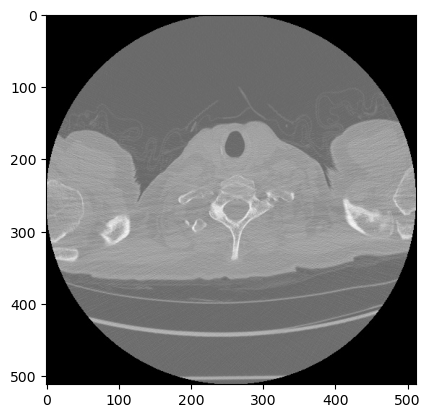

In [80]:
img_ex = load_images_or_masks_to_ram(image_paths[0],False,image_dtype_to_display)
plt.imshow(img_ex)
print(img_ex.shape)
np.unique(img_ex)

(512, 512, 3)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,
        94,  96,  98,  99, 102, 108, 109, 114, 115, 122, 123, 124, 125,
       128, 131, 134, 137, 138, 140, 144, 145, 146, 147, 152, 153, 154,
       156, 157, 158, 160, 161, 162, 163, 164, 165, 168, 169, 170, 171,
       172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 224, 22

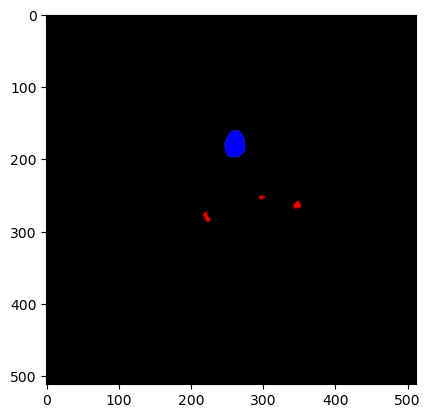

In [81]:
mask_ex = load_images_or_masks_to_ram(mask_paths[0],True,mask_dtype)
plt.imshow(mask_ex)
print(mask_ex.shape)
np.unique(mask_ex)

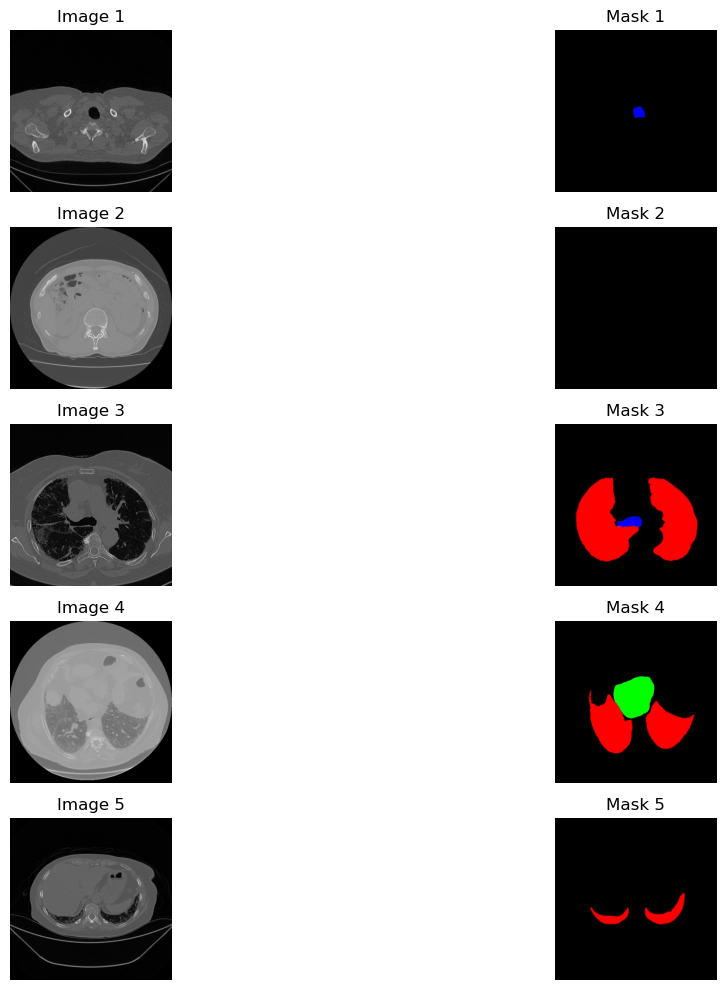

In [10]:
# Number of random images to display
num_random_display = 5

# Generate random indices to select images from the list
random_indices = np.random.randint(0, len(image_paths), size=num_random_display)

# Load random images into memory using the specified dtype
random_images = [load_images_or_masks_to_ram(image_paths[i], False, image_dtype_to_display) for i in random_indices]

# Load corresponding random masks into memory using the specified dtype
random_masks = [load_images_or_masks_to_ram(mask_paths[i], True, mask_dtype) for i in random_indices]

# Display the selected images and masks side by side with titles
show_images_side_by_side(random_images, random_masks, title1="Image", title2="Mask")


Processed Image Shape: (256, 256, 3)
Unique Values in Processed Image: [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.32

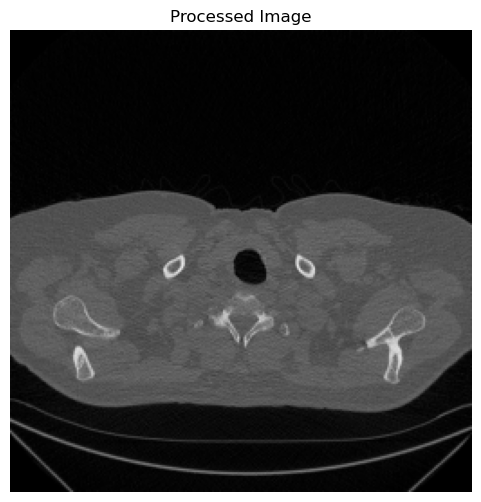

In [11]:
# Function to process an image for model input
def process_image(image):
    """
    Processes the input image by resizing, normalizing, and converting it to the specified data type.
    
    Parameters:
    -----------
    image : ndarray
        The input image to process.
        
    Returns:
    --------
    ndarray
        The processed image ready for model input.
    """
    # Resize the image to the specified input shape
    image = cv.resize(image, input_shape)
    
    # Normalize the image to the range [0, 1]
    image = image / 255.0
    
    # Preprocess the image using the defined preprocessing function
    image = preprocess_input(image)
    
    # Convert the image to the specified data type for training
    image = np.array(image).astype(image_dtype_to_train)

    return image

# Visualization after applying the processing on a random image
image_after_processing = process_image(random_images[0])

# Print the shape and unique values of the processed image for verification
print("Processed Image Shape:", image_after_processing.shape)
print("Unique Values in Processed Image:", np.unique(image_after_processing))

# Display the processed image
plt.figure(figsize=(6, 6))
plt.imshow(image_after_processing)
plt.title("Processed Image")
plt.axis('off')  # Hide axes for better visualization
plt.show()


Processed Mask Shape: (256, 256)
Unique Values in Processed Mask: [0 1 2 3]


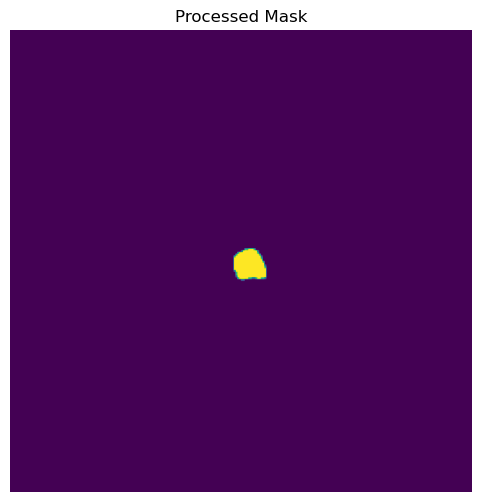

In [12]:
 

def reclassify_rgb_mask_to_four_classes(mask):
    """
    Reclassifies an RGB mask into four distinct classes based on color channels.
    
    Parameters:
    -----------
    mask : ndarray
        The input RGB mask image with 3 channels.
        
    Returns:
    --------
    new_mask : ndarray
        The reclassified mask with 4 classes (0 to 3).
    """
    # Ensure the mask is an RGB image with 3 channels
    assert mask.shape[-1] == 3, "The mask should be an RGB image with 3 channels."
    
    # Extract RGB channels
    r_channel = mask[:, :, 0]   
    g_channel = mask[:, :, 1]  
    b_channel = mask[:, :, 2]  
    
    # Initialize a new mask with zeros
    new_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)  

    # Reclassify colors to four classes
    new_mask[(r_channel == 0) & (g_channel == 0) & (b_channel == 0)] = 0  # Black
    new_mask[(r_channel > 150) & (g_channel < 100) & (b_channel < 100)] = 1  # Red
    new_mask[(r_channel < 100) & (g_channel > 150) & (b_channel < 100)] = 2  # Green
    new_mask[(r_channel < 100) & (g_channel < 100) & (b_channel > 150)] = 3  # Blue
    
    return new_mask

def process_mask(mask):
    """
    Processes the input mask by reclassifying it and resizing.
    
    Parameters:
    -----------
    mask : ndarray
        The input RGB mask image with 3 channels.
        
    Returns:
    --------
    mask : ndarray
        The processed mask with resized and reclassified values.
    """
    # Reclassify the mask into four classes
    mask = reclassify_rgb_mask_to_four_classes(mask)
    
    # Resize the mask to the input shape
    mask = cv.resize(mask, input_shape)
    
    # Convert the mask to float32
    mask = mask.astype(mask_dtype)
    
    return mask

# Visualization after applying the processing on a random mask
mask_after_processing = process_mask(random_masks[0])

# Print the shape and unique values of the processed mask for verification
print("Processed Mask Shape:", mask_after_processing.shape)
print("Unique Values in Processed Mask:", np.unique(mask_after_processing))

# Display the processed mask
plt.figure(figsize=(6, 6))
plt.imshow(mask_after_processing)  # Use 'gray' colormap for better visibility
plt.title("Processed Mask")
plt.axis('off')  # Hide axes for better visualization
plt.show()


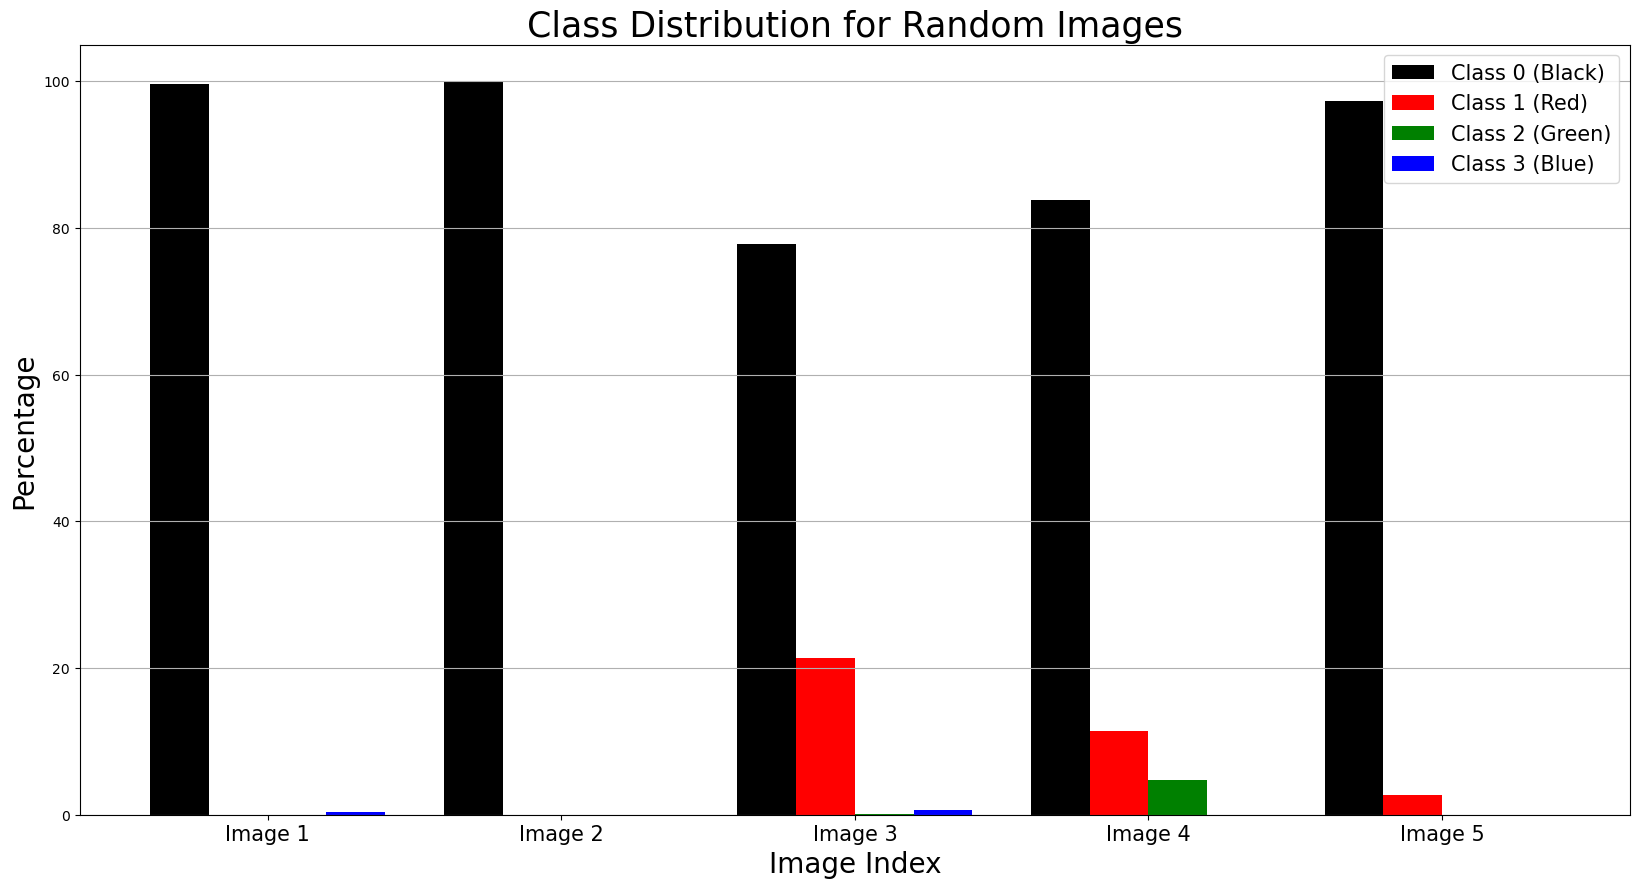

In [13]:
def calculate_class_distribution(mask):
    unique, counts = np.unique(mask, return_counts=True)
    total_pixels = mask.size
    
    distribution = [0] * 4  # Assuming you have 4 classes (0 to 3)
    for i in range(len(unique)):
        if unique[i] < len(distribution):
            distribution[unique[i]] = (counts[i] / total_pixels) * 100
            
    return distribution

# Process random masks and calculate distributions
class_distributions = [calculate_class_distribution(process_mask(random_masks[i])) for i in range(num_random_display)]

# Set up for plotting
labels = ['Class 0 (Black)', 'Class 1 (Red)', 'Class 2 (Green)', 'Class 3 (Blue)']
num_classes = len(labels)

# Set up the plot
x = np.arange(num_random_display)  # x-axis for the number of images
width = 0.2  # Width of the bars
colors = ['black', 'red', 'green', 'blue']  # Specify colors for each class

plt.figure(figsize=(20, 10))  # Increase the size

# Plot each class for each image
for i in range(num_classes):
    distribution_values = [distribution[i] for distribution in class_distributions]
    plt.bar(x + i * width, distribution_values, width, label=labels[i], color=colors[i])  # Assign colors

# Set up plot settings
plt.xlabel('Image Index', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.title('Class Distribution for Random Images', fontsize=25)
plt.xticks(x + width * (num_classes - 1) / 2, [f'Image {i+1}' for i in range(num_random_display)], fontsize=15)
plt.legend(fontsize=15)
plt.grid(axis='y')

plt.show()


In [61]:
mask_paths

['ID00007637202177411956430_mask_0.jpg',
 'ID00007637202177411956430_mask_1.jpg',
 'ID00007637202177411956430_mask_10.jpg',
 'ID00007637202177411956430_mask_11.jpg',
 'ID00007637202177411956430_mask_12.jpg',
 'ID00007637202177411956430_mask_13.jpg',
 'ID00007637202177411956430_mask_14.jpg',
 'ID00007637202177411956430_mask_15.jpg',
 'ID00007637202177411956430_mask_16.jpg',
 'ID00007637202177411956430_mask_17.jpg',
 'ID00007637202177411956430_mask_18.jpg',
 'ID00007637202177411956430_mask_19.jpg',
 'ID00007637202177411956430_mask_2.jpg',
 'ID00007637202177411956430_mask_20.jpg',
 'ID00007637202177411956430_mask_21.jpg',
 'ID00007637202177411956430_mask_22.jpg',
 'ID00007637202177411956430_mask_23.jpg',
 'ID00007637202177411956430_mask_24.jpg',
 'ID00007637202177411956430_mask_25.jpg',
 'ID00007637202177411956430_mask_26.jpg',
 'ID00007637202177411956430_mask_27.jpg',
 'ID00007637202177411956430_mask_28.jpg',
 'ID00007637202177411956430_mask_29.jpg',
 'ID00007637202177411956430_mask_3.jp

In [62]:
# 1. Load and process the masks
masks = [process_mask(load_images_or_masks_to_ram(mask_path, True, dtype=mask_dtype)) for mask_path in mask_paths]


# 2. Flatten all masks into a single array
y_true = np.concatenate([mask.flatten() for mask in masks])  # Concatenate all masks into a single array

# 3. Extract unique class labels and count samples for each class
class_labels = np.unique(y_true)  # Extract all unique classes
class_counts = [np.sum(y_true == label) for label in class_labels]  # Count the number of samples for each class

# 4. Calculate class weights
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_true)  # Compute weights based on class counts
class_weights_dict = dict(zip(class_labels, class_weights))  # Create a dictionary mapping classes to their weights

# 5. Clear masks from memory
del masks  # Delete masks to free memory
del y_true  # Clean up y_true data if no longer needed

# 6. Print class weights
print(class_weights_dict)  # Print class weights for review


{0: 0.2793728385460172, 1: 2.7326509242950703, 2: 20.26962739925566, 3: 189.6078523997099}


In [64]:
import json

# Convert keys to int (if they are not already)
class_weights_dict_int = {int(k): v for k, v in class_weights_dict.items()}

# Save class weights to a JSON file
with open('class_weights.json', 'w') as f:
    json.dump(class_weights_dict_int, f)




{'0': 0.2793728385460172, '1': 2.7326509242950703, '2': 20.26962739925566, '3': 189.6078523997099}


In [18]:
import json
# To load them later:
with open('class_weights.json', 'r') as f:
    loaded_class_weights = json.load(f)

print(loaded_class_weights)

{'0': 0.2793728385460172, '1': 2.7326509242950703, '2': 20.26962739925566, '3': 189.6078523997099}


In [14]:
def weighted_dice_loss_and_cross_entropy(weights):
    def loss(y_true, y_pred):
        # Categorical Cross-Entropy Loss with weights
        cce = tf.keras.losses.CategoricalCrossentropy()
        cce_loss = cce(y_true, y_pred)
        
        # Dice Loss
        dice_loss = sm.losses.DiceLoss()(y_true, y_pred)
        
        # Apply class weights
        weights_tensor = tf.convert_to_tensor(weights, dtype=tf.float32)
        
        weights_applied = K.sum(y_true * weights_tensor, axis=-1)
        
        # Final loss: weighted sum of Dice Loss and Categorical Cross-Entropy
        return K.mean(cce_loss * weights_applied + dice_loss)
    
    return loss

In [15]:
X_train , X_val_test ,  y_train ,  y_val_test = train_test_split(image_paths,mask_paths , test_size=0.2 , random_state=42)

x_val ,x_test, y_val , y_test = train_test_split(X_val_test,y_val_test , test_size=0.5 , random_state=42)


In [88]:
def batch_generator(image_paths, mask_paths, batch_size):
    dataset_size = len(image_paths)
    
    while True:
        for i in range(0, dataset_size, batch_size):
            batch_image_paths = image_paths[i:i + batch_size]
            batch_mask_paths = mask_paths[i:i + batch_size]
            
            images = []
            masks = []
            
            for img_path, mask_path in zip(batch_image_paths, batch_mask_paths):
                image = load_images_or_masks_to_ram(img_path,False,dtype=image_dtype_to_train)
                mask = load_images_or_masks_to_ram(mask_path,True,dtype=mask_dtype )
                mask = to_categorical(process_mask(mask), num_classes=num_classes)
                images.append(process_image(image))
                masks.append(mask)
                
            
            images = np.array(images)
            masks = np.array(masks)

            
            
          
            
            
            yield images, masks


In [23]:
loss_function = weighted_dice_loss_and_cross_entropy(loaded_class_weights)

In [95]:
# Define the function to create the model

def create_model(input_shape, num_classes, backbone, freeze_encoder):
    # Define the U-Net model with the specified backbone
    model = sm.Unet(
        backbone,
        input_shape=input_shape + (3,),  # Add 3 for RGB channels
        classes=num_classes,
        activation='softmax',  # Softmax for multi-class segmentation
        encoder_weights='imagenet' if not freeze_encoder else None  # Use pre-trained weights if not freezing
    )
    return model

# Create the model
model = create_model(input_shape, num_classes, BACKBONE, freeze_encoder)

# Compile the model
model.compile(
    optimizer= optimizer,  
    loss=loss_function,  # Dice Loss for segmentation
    metrics=metrics  # Metrics to evaluate the model
)

# Print the model summary to review architecture
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

In [90]:
train_generator = batch_generator(X_train, y_train, batch_size)
val_generator = batch_generator(x_val, y_val, batch_size)

In [92]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor=early_stopping_monitor,  # Metric to monitor
    patience=early_stopping_patience,  # Patience before stopping
    min_delta=early_stopping_min_delta,  # Minimum change to qualify as improvement
    mode='min', # Minimize the loss
    restore_best_weights=True  # Restore weights from the best epoch
)

In [96]:
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(x_val) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch ,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/50
1336/1336 [==============================] - 950s 705ms/step - loss: 0.4899 - iou_score: 0.5579 - f1-score: 0.6540 - val_loss: 0.3866 - val_iou_score: 0.6246 - val_f1-score: 0.7269
Epoch 2/50
1336/1336 [==============================] - 963s 721ms/step - loss: 0.3369 - iou_score: 0.6665 - f1-score: 0.7627 - val_loss: 0.3819 - val_iou_score: 0.6661 - val_f1-score: 0.7603
Epoch 3/50
1336/1336 [==============================] - 963s 721ms/step - loss: 0.2616 - iou_score: 0.7287 - f1-score: 0.8130 - val_loss: 0.2565 - val_iou_score: 0.7344 - val_f1-score: 0.8175
Epoch 4/50
1336/1336 [==============================] - 962s 720ms/step - loss: 0.2109 - iou_score: 0.7685 - f1-score: 0.8447 - val_loss: 0.2048 - val_iou_score: 0.7802 - val_f1-score: 0.8529
Epoch 5/50
1336/1336 [==============================] - 962s 720ms/step - loss: 0.1856 - iou_score: 0.7889 - f1-score: 0.8600 - val_loss: 0.1994 - val_iou_score: 0.7789 - val_f1-score: 0.8519
Epoch 6/50
1336/1336 [==================

In [97]:
model.save('multi_segementaion_model.h5')

In [25]:

model = load_model('multi_segementaion_model.h5', custom_objects={'iou_score': sm.metrics.IOUScore(), 'f1-score': sm.metrics.FScore(),'loss': loss_function})

In [55]:
images_t = []
masks_t = []
for i in range(0, len(x_test)):
     image = load_images_or_masks_to_ram(x_test[i],False,dtype=image_dtype_to_train)
     mask = load_images_or_masks_to_ram(y_test[i],True,dtype=mask_dtype )
     mask = to_categorical(process_mask(mask), num_classes=num_classes)
     images_t.append(process_image(image))
     masks_t.append(mask)
        
    
images_t = np.array(images_t,dtype=np.float32)
masks_t = np.array(masks_t,dtype=np.uint8)


In [148]:
len(images_t)

500

In [57]:
K.clear_session()
gc.collect()

105

In [58]:

def predict_in_batches(model, images, batch_size):
    """
    Perform predictions in batches and store the results in a list.

    Args:
        model: Trained Keras model used for prediction.
        images: Numpy array or list of images for prediction.
        batch_size: Number of images per batch.

    Returns:
        A list containing predictions for all images.
    """
    num_images = len(images)
    num_batches = int(np.ceil(num_images / batch_size))
    
    # List to store all predictions
    all_predictions = []
    
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, num_images)
        
        # Extract the current batch of images
        batch_images = images[start_index:end_index]
        
        # Perform prediction for the current batch
        predictions = model.predict(batch_images, batch_size=batch_size)
        
        # Append predictions to the list
        all_predictions.append(predictions)
        
        print(f"Processed batch {batch_index + 1}/{num_batches}")
    
    # Flatten the list of batches into a single list of predictions
    return np.vstack(all_predictions)

# Usage example
batch_size = 10  # Set your preferred batch size
predictions = predict_in_batches(model, images_t, batch_size)


1/1 [==============================] - 3s 3s/step
Processed batch 1/168
1/1 [==============================] - 0s 40ms/step
Processed batch 2/168
1/1 [==============================] - 0s 41ms/step
Processed batch 3/168
1/1 [==============================] - 0s 36ms/step
Processed batch 4/168
1/1 [==============================] - 0s 40ms/step
Processed batch 5/168
1/1 [==============================] - 0s 40ms/step
Processed batch 6/168
1/1 [==============================] - 0s 36ms/step
Processed batch 7/168
1/1 [==============================] - 0s 31ms/step
Processed batch 8/168
1/1 [==============================] - 0s 51ms/step
Processed batch 9/168
1/1 [==============================] - 0s 35ms/step
Processed batch 10/168
1/1 [==============================] - 0s 32ms/step
Processed batch 11/168
1/1 [==============================] - 0s 48ms/step
Processed batch 12/168
1/1 [==============================] - 0s 42ms/step
Processed batch 13/168
1/1 [==============================]

In [59]:

predictions = np.argmax(predictions, axis=-1)

In [60]:
true_masks = np.argmax(masks_t, axis=-1)
np.unique(masks_t[0])

array([0, 1], dtype=uint8)

In [131]:
len(x_test)

1671

Class 0: IoU = 0.9924, F1 Score = 0.9962
Class 1: IoU = 0.9484, F1 Score = 0.9735
Class 2: IoU = 0.8154, F1 Score = 0.8983
Class 3: IoU = 0.8176, F1 Score = 0.8996


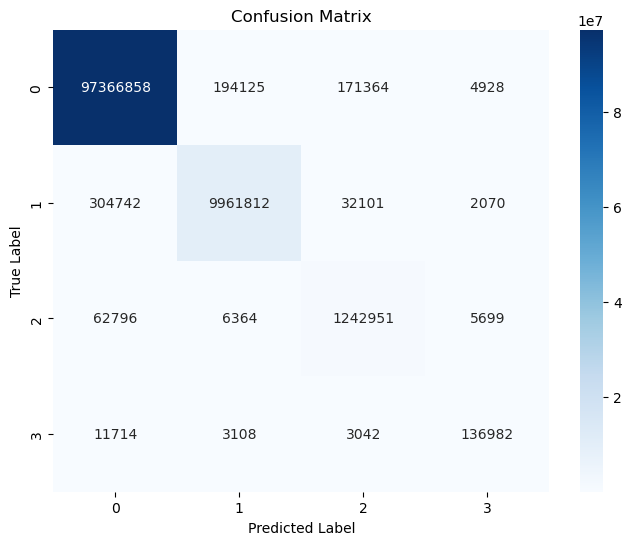

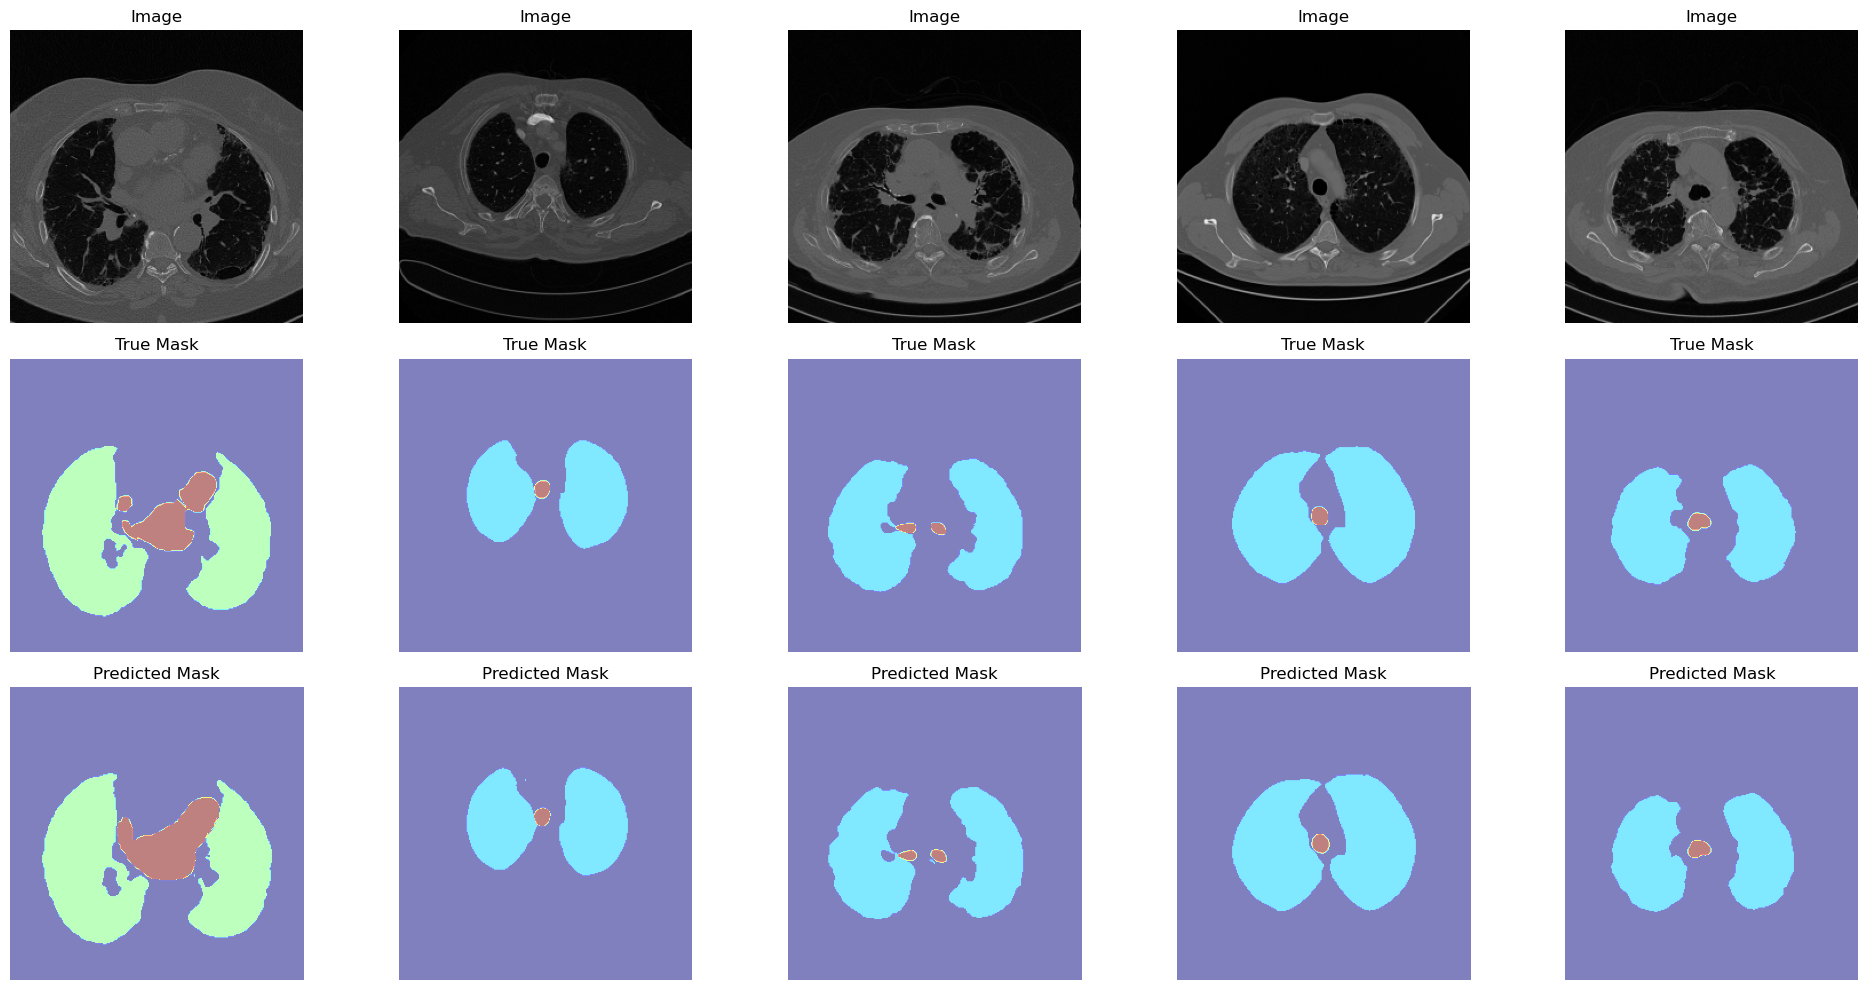

In [61]:

 

def calculate_metrics(true_masks, predictions, num_classes):
    metrics = {}
    
    for class_id in range(num_classes):
        true_class = (true_masks == class_id).astype(np.float32)
        pred_class = (predictions == class_id).astype(np.float32)
        
        intersection = np.sum(true_class * pred_class)
        union = np.sum(true_class) + np.sum(pred_class) - intersection
        
        iou = intersection / (union + 1e-6)  
        f1_score = 2 * intersection / (np.sum(true_class) + np.sum(pred_class) + 1e-6)
        
        metrics[class_id] = {
            'IoU': iou,
            'F1 Score': f1_score,
            'True Positives': np.sum(true_class * pred_class),
            'False Positives': np.sum((1 - true_class) * pred_class),
            'False Negatives': np.sum(true_class * (1 - pred_class))
        }
    
    return metrics

num_classes = 4   
metrics = calculate_metrics(true_masks, predictions, num_classes)

 
for class_id, class_metrics in metrics.items():
    print(f"Class {class_id}: IoU = {class_metrics['IoU']:.4f}, F1 Score = {class_metrics['F1 Score']:.4f}")

 
cm = confusion_matrix(true_masks.flatten(), predictions.flatten(), labels=np.arange(num_classes))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

 
n_samples = 5  
plt.figure(figsize=(20, 10))
for i in range(n_samples):
     
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(images_t[i])
    plt.title("Image")
    plt.axis("off")
    
     
    plt.subplot(3, n_samples, n_samples + i + 1)
    plt.imshow(true_masks[i], cmap='jet', alpha=0.5)
    plt.title("True Mask")
    plt.axis("off")
    
     
    plt.subplot(3, n_samples, 2 * n_samples + i + 1)
    plt.imshow(predictions[i], cmap='jet', alpha=0.5)
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
